In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Dec 19 17:08:19 2024

@author: Rodrigo Meira
"""
from libs.eos_database import *
from libs.compressor_class import *
from libs.compression import *
from libs.gc_eos_soave import *
from libs.viscosity import *
from libs.plenum_system import *
from libs.simulation import *
from libs.model import *

from casadi import *
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import torch
from scipy.stats import qmc
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
list_names = ["CH4", "C2H6", "C3H8", "iC4H10", "nC4H10", "iC5H12", "nC5H12", 
                  "nC6H14", "nC7H16", "nC8H18", "nC9H20", "nC10H22", "nC11H24", 
                   "nC12H26", "nC14H30", "N2", "H2O", "CO2", "C15+"]

nwe = [0.9834, 0.0061, 0.0015, 0.0003, 0.0003, 0.00055, 0.0004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003, 0.0, 0.0008, 0.0]

dict_composition= {list_names[i]: nwe[i] for i in range(len(nwe))}

mixture = Mixture(list_of_species, dict_composition)

volumn_desviation = [0] * 19

vlv = valve(kv=0.38)
Vpp = 2.0 
Lc = 2.0 
A1 = 2.6e-3
gas = gc_eos_class(mixture, 300, 4500, None, 1, 0, Aij, volumn_desviation, 'gas')
comp = CompressorClass()
visc = viscosity(mixture, volumn_desviation)
compressor = compression(gas, comp, visc)
plenum_sys = plenum(gas, compressor, vlv, Vpp, Lc, A1)

In [3]:
nAlphas = 300

sampler_N_RotS = qmc.LatinHypercube(d=1)  # d=1 porque estamos amostrando uma única variável
samples_N_RotS = sampler_N_RotS.random(n=nAlphas+1)
N_RotS = qmc.scale(samples_N_RotS, 600, 750).flatten()  # Redimensiona para 1D
sampler_alphas = qmc.LatinHypercube(d=1)
samples_alphas = sampler_alphas.random(n=nAlphas+1)
alphas = qmc.scale(samples_alphas, 0.36, 0.65).flatten()

nData = 160
dt = 0.5
timestep = 3
x0 = [14.9919, 339.69, 0.42885]
z0 = [6245.39, 6245.39, 321.672, 0.445562, 319.423, 0.503621, 320.097, 0.396345, 339.69, 0.42885, 0.514917]
u0 = [4500, 300, 600, alphas[0], 5000]

In [4]:
# sim = Simulation(plenum_sys, compressor, x0, z0, u0, nAlphas, alphas, N_RotS, nData, dt, timestep)
# x_values, z_values, time_steps, alpha_values, N_values, x_train, y_train, x_min, x_max, y_min,y_max = sim.run()

# sim_data = {
#     "x_values": x_values,
#     "z_values": z_values,
#     "time_steps": time_steps,
#     "x_train": x_train,
#     "y_train": y_train,
#     "x_min": x_min,
#     "x_max": x_max,
#     "y_min": y_min,
#     "y_max": y_max

# }

# np.savez(
#     "simulation_data.npz",
#     x_values=x_values,
#     z_values=z_values,
#     time_steps=time_steps,
#     alpha_values=alpha_values,
#     N_values=N_values,
#     x_train=x_train,
#     y_train=y_train,
#     x_min=x_min,
#     x_max=x_max,
#     y_min = y_min,
#     y_max = y_max

# )


In [4]:
data = np.load("simulation_data.npz")

x_values = data["x_values"]
z_values = data["z_values"]
time_steps = data["time_steps"]
alpha_values = data["alpha_values"]
N_values = data["N_values"]
x_train = data["x_train"]
y_train = data["y_train"]
x_min = data["x_min"]
x_max = data["x_max"]
y_min = data["y_min"]
y_max = data["y_max"]


x_min = torch.tensor(x_min, dtype = torch.float32)
x_max = torch.tensor(x_max, dtype = torch.float32)
y_min = torch.tensor(y_min, dtype = torch.float32)
y_max = torch.tensor(y_max, dtype = torch.float32)
x_train = torch.tensor(np.array(x_train), dtype=torch.float32)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32)
x_train_split, X_val, y_train_split, y_val = train_test_split(
    x_train, 
    y_train, 
    test_size=0.3,  
    random_state=42,  
    shuffle=True      
)
y_train_split = y_train_split.squeeze()
y_val = y_val.squeeze()
train_dataset = torch.utils.data.TensorDataset(x_train_split, y_train_split)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= 64, shuffle=True)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size= 64, shuffle=False)

In [6]:
model = MyModel(150, dt, x_max, x_min, y_min, y_max, plenum_sys)# Criar a instância do modelo novamente

In [7]:
# modelo = MyModel(200, dt, x_max, x_min, y_min, y_max, plenum_sys)  # mesma definição usada antes
# modelo.load_state_dict(torch.load('pesos_modelo.pth'))


In [8]:
train_loss_values = model.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    lr= 1e-4,
    epochs=25,
    optimizers=torch.optim.Adam,
    patience=2,
    factor=0.5,
    gas = gas
)

Batch 0 completed in 6.29s | Data: 28703.4570 | Phys: 2758.2764
Batch 1 completed in 3.39s | Data: 33051.6875 | Phys: 2911.0667
Batch 2 completed in 3.34s | Data: 27770.0449 | Phys: 2530.0964
Batch 3 completed in 3.41s | Data: 20325.0273 | Phys: 2612.6284
Batch 4 completed in 3.42s | Data: 31655.2754 | Phys: 3408.5710
Batch 5 completed in 3.44s | Data: 24717.5078 | Phys: 2086.8264
Batch 6 completed in 3.57s | Data: 27173.0156 | Phys: 2462.3420
Batch 7 completed in 3.45s | Data: 31395.7520 | Phys: 2699.6130
Batch 8 completed in 0.44s | Data: 24283.8438 | Phys: 2121.8101
Batch 9 completed in 3.46s | Data: 21525.9727 | Phys: 2858.4504
Batch 10 completed in 3.42s | Data: 22560.9121 | Phys: 3003.9387
Batch 11 completed in 3.38s | Data: 22069.2148 | Phys: 2700.7776
Batch 12 completed in 3.36s | Data: 20142.6484 | Phys: 2118.8401
Batch 13 completed in 3.43s | Data: 20122.6562 | Phys: 2417.2361
Batch 14 completed in 3.42s | Data: 21613.7734 | Phys: 3224.6621
Batch 15 completed in 3.41s | Data:

/home/matheus/Trabalho/UFBA/New_project/libs/model.py:51: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  sol = fsolve(self.system_residuals, z0, args=(x0, u0, plenum_sys))


Batch 227 completed in 2.75s | Data: 4.1288 | Phys: 0.9327
Batch 228 completed in 2.72s | Data: 793.6726 | Phys: 1.8700
Batch 229 completed in 2.69s | Data: 103.6722 | Phys: 6.8414
Batch 230 completed in 2.68s | Data: 523.2381 | Phys: 1.6405
Batch 231 completed in 2.69s | Data: 10.3659 | Phys: 1.1342
Batch 232 completed in 2.67s | Data: 515.2166 | Phys: 8.7954
Batch 233 completed in 2.69s | Data: 32.2032 | Phys: 1.9209
Batch 234 completed in 2.67s | Data: 148.4330 | Phys: 7.4332
Batch 235 completed in 2.67s | Data: 87.6140 | Phys: 10.1392
Batch 236 completed in 2.69s | Data: 1127.4310 | Phys: 53.5299
Batch 237 completed in 2.65s | Data: 128.9474 | Phys: 7.5940
Batch 238 completed in 2.71s | Data: 28.0587 | Phys: 5.3285
Batch 239 completed in 2.66s | Data: 16.9395 | Phys: 7.0339
Batch 240 completed in 2.72s | Data: 14.5450 | Phys: 3.4272
Batch 241 completed in 2.67s | Data: 12.4775 | Phys: 1.8945
Batch 242 completed in 2.68s | Data: 7.6223 | Phys: 1.6507
Batch 243 completed in 2.66s | D

/home/matheus/Trabalho/UFBA/New_project/libs/model.py:51: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  sol = fsolve(self.system_residuals, z0, args=(x0, u0, plenum_sys))


Batch 389 completed in 2.76s | Data: 8.9676 | Phys: 3.5600
Batch 390 completed in 2.73s | Data: 5.0012 | Phys: 1.2379
Batch 391 completed in 2.72s | Data: 28.9901 | Phys: 8.6401
Batch 392 completed in 2.58s | Data: 225.1419 | Phys: 0.9025
Batch 393 completed in 2.66s | Data: 18.9430 | Phys: 5.6433
Batch 394 completed in 2.66s | Data: 6.6602 | Phys: 2.5978
Batch 395 completed in 2.67s | Data: 11.5652 | Phys: 2.6197
Batch 396 completed in 2.66s | Data: 526.4899 | Phys: 1.7412
Batch 397 completed in 2.77s | Data: 38.7355 | Phys: 2.4762
Batch 398 completed in 2.67s | Data: 6.7639 | Phys: 0.5787
Batch 399 completed in 2.73s | Data: 22.5966 | Phys: 6.5042
Batch 400 completed in 2.69s | Data: 177.3416 | Phys: 2.1811
Batch 401 completed in 2.72s | Data: 27.8208 | Phys: 8.0844
Batch 402 completed in 2.70s | Data: 520.3011 | Phys: 12.4564
Batch 403 completed in 2.68s | Data: 155.6582 | Phys: 7.2726
Batch 404 completed in 2.65s | Data: 115.6569 | Phys: 6.3360
Batch 405 completed in 2.66s | Data: 

/home/matheus/Trabalho/UFBA/New_project/libs/model.py:51: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  sol = fsolve(self.system_residuals, z0, args=(x0, u0, plenum_sys))


Batch 46 completed in 2.80s | Data: 2.2697 | Phys: 1.1318
Batch 47 completed in 2.70s | Data: 4.4521 | Phys: 3.0759
Batch 48 completed in 2.13s | Data: 2.3703 | Phys: 1.6935
Batch 49 completed in 2.70s | Data: 5.5405 | Phys: 2.1674
Batch 50 completed in 2.70s | Data: 83.7070 | Phys: 2.4484
Batch 51 completed in 2.69s | Data: 8.3799 | Phys: 4.8626
Batch 52 completed in 2.72s | Data: 15.4913 | Phys: 7.4038
Batch 53 completed in 2.72s | Data: 3.4105 | Phys: 2.7984
Batch 54 completed in 2.71s | Data: 4.3567 | Phys: 3.6921
Batch 55 completed in 2.72s | Data: 39.7901 | Phys: 4.2196
Batch 56 completed in 2.69s | Data: 5.2139 | Phys: 1.1223
Batch 57 completed in 2.77s | Data: 2.2327 | Phys: 0.9295
Batch 58 completed in 2.72s | Data: 7.4295 | Phys: 3.5858
Batch 59 completed in 2.72s | Data: 11.6273 | Phys: 2.6834
Batch 60 completed in 2.11s | Data: 2.1529 | Phys: 1.1744
Batch 61 completed in 2.73s | Data: 159.4294 | Phys: 1.1199
Batch 62 completed in 2.67s | Data: 21.1179 | Phys: 6.2203
Batch 6

In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [47]:
nAlphas_teste = 7

sampler_N_RotS_teste = qmc.LatinHypercube(d=1)  # d=1 porque estamos amostrando uma única variável
samples_N_RotS_teste = sampler_N_RotS_teste.random(n=nAlphas_teste+1)
N_RotS_teste = qmc.scale(samples_N_RotS_teste, 600, 750).flatten()  # Redimensiona para 1D
sampler_alphas_teste = qmc.LatinHypercube(d=1)
samples_alphas_teste = sampler_alphas_teste.random(n=nAlphas_teste+1)
alphas_teste = qmc.scale(samples_alphas_teste, 0.35, 0.65).flatten()  

sim2 = sim = Simulation(plenum_sys, compressor, x0, z0, u0, nAlphas_teste, alphas_teste, N_RotS_teste, 160, dt, timestep)
x_values_teste, z_values_teste, time_steps, alpha_values_teste, N_values_teste, x_teste, y_teste, x_min, x_max, y_min, y_max = sim.run()
interval3 = np.linspace(0, 160*nAlphas_teste, len(x_teste))

In [ ]:
import torch

# Rodar a inferência corretamente
model.eval()  # Importante colocar a rede em modo de avaliação
with torch.no_grad():
    y_pred = model(x_teste)

# Checar se y_pred realmente varia
for name, param in model.named_parameters():
    print(f"{name}: mean={param.mean().item()}, std={param.std().item()}")



In [ ]:
# torch.onnx.export(
#     model,
#     x_teste,
#     "modelo_simples13.onnx",
#     export_params=True,
#     opset_version=17,
#     input_names=["input"],
#     output_names=["output"],
#     dynamic_axes={
#         "input": {0: "batch_size"},  # Permite batch variável
#         "output": {0: "batch_size"},
#     },
# )

/home/matheus/.local/lib/python3.12/site-packages/torch/onnx/symbolic_opset9.py:4277: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [48]:
import onnxruntime as ort
import numpy as np

# Converter o tensor para NumPy e ajustar o dtype
x_teste_np = x_teste.detach().cpu().numpy().astype(np.float32)  # Garanta float32

# Se o modelo esperar um batch dimension (ex: [batch, seq_len, features]), adicione:
if x_teste_np.ndim == 1:
    x_teste_np = x_teste_np[np.newaxis, ...]  # Adiciona dimensão de batch (batch=1)

# Carregar o modelo ONNX
ort_session = ort.InferenceSession("modelo_simples13.onnx")

# Executar inferência corretamente
input_name = ort_session.get_inputs()[0].name
outputs = ort_session.run(None, {input_name: x_teste_np})[0]

In [ ]:
import matplotlib.pyplot as plt

# Remover dimensões extras de y_pred e y_teste (se houver)
outputs = outputs.squeeze()
y_teste = y_teste.squeeze()

# Número de variáveis de saída
num_outputs = y_teste.shape[1]

# Ajustar o tamanho da lista time_steps para corresponder aos dados de teste
time_steps = time_steps[:y_teste.shape[0]]
 
# Criar os gráficos separadamente para cada saída
for i in range(num_outputs):
    plt.figure(figsize=(8, 4))  # Criar uma nova figura para cada gráfico
    plt.plot(time_steps, y_teste[:, i], label="Saída Esperada (y_teste)", color="red", linestyle="--")
    plt.plot(time_steps, outputs[:, i], label="Saída da Rede (outputs)", color="blue", linestyle="-")
    
    plt.xlabel("Time Step")
    plt.ylabel("Valor")
    plt.title(f"Saída {i}")  # Título do gráfico indicando o índice da saída
    plt.legend()
    plt.grid(True)
    
    plt.show()  # Mostrar o gráfico

"[0, 1, 2, 3, 5, 7, 9, 11]"

In [ ]:
print(x_teste.shape)

In [49]:
onnx_model_path = "./modelo_simples13.onnx"
onnx_session = ort.InferenceSession(onnx_model_path)


# Iniciar listas com os 3 primeiros passos
massFlowrate_pred = [x_teste[0, 0, 0].item(), x_teste[0, 1, 0].item(), x_teste[0, 2, 0].item()]
Temperatura_pred = [x_teste[0, 0, 1].item(), x_teste[0, 1, 1].item(), x_teste[0, 2, 1].item()]
PlenumPressure_pred = [x_teste[0, 0, 2].item(), x_teste[0, 1, 2].item(), x_teste[0, 2, 2].item()]
Pressure2_pred = [x_teste[0, 0, 3].item(), x_teste[0, 1, 3].item(), x_teste[0, 2, 3].item()]
Temperatura2_pred = [x_teste[0, 0, 4].item(), x_teste[0, 1, 4].item(), x_teste[0, 2, 4].item()]

input_tensor = torch.zeros((1, 3, 7), dtype=torch.float32)

# Lista para armazenar TODAS as predições (com 14 variáveis por passo)
all_predictions = []

tm1 = time.time()

for i in range(len(interval3)):
    # Atualiza as entradas com as 3 últimas predições
    input_tensor[0, :, 0] = torch.tensor(massFlowrate_pred[-3:])
    input_tensor[0, :, 1] = torch.tensor(Temperatura_pred[-3:])
    input_tensor[0, :, 2] = torch.tensor(PlenumPressure_pred[-3:])
    input_tensor[0, :, 3] = torch.tensor(Pressure2_pred[-3:])
    input_tensor[0, :, 4] = torch.tensor(Temperatura2_pred[-3:])
    input_tensor[0, :, 5] = x_teste[i, :, 5]
    input_tensor[0, :, 6] = x_teste[i, :, 6]

    # Previsão com ONNX
    onnx_inputs = {'input': input_tensor.numpy()}
    onnx_outputs = onnx_session.run(None, onnx_inputs)
    output_step = onnx_outputs[0][0]  # vetor de 14 saídas

    # Armazena toda a predição
    all_predictions.append(output_step)

    # Atualiza as listas para retroalimentação (opcional)
    massFlowrate_pred.append(output_step[0])
    Temperatura_pred.append(output_step[1])
    PlenumPressure_pred.append(output_step[3])
    Pressure2_pred.append(output_step[4])
    Temperatura2_pred.append(output_step[11])

tm2 = time.time()
timeteste = tm2 - tm1

print(f"Tempo de teste: {timeteste:.4f}s")

# Converter para array numpy
all_predictions = np.array(all_predictions)  # shape (N, 14)
y_true = y_teste
  # pula os 3 primeiros passos do warm-up

# Avaliar R² e RMSE
r2_list = []
rmse_list = []
print(y_teste.shape)
print(all_predictions.shape)
for i in range(14):
    r2 = r2_score(y_true[:, i], all_predictions[:, i])
    rmse = np.sqrt(mean_squared_error(y_true[:, i], all_predictions[:, i]))
    r2_list.append(r2)
    rmse_list.append(rmse)

# Exibir resultados
print("\nMétricas por variável:")
for i in range(14):  # Para todas as variáveis de 0 a 13
    print(f"Variável {i} | R² = {r2_list[i]:.4f} | RMSE = {rmse_list[i]:.6f}")



Tempo de teste: 0.2804s
torch.Size([1117, 14])
(1117, 14)

Métricas por variável:
Variável 0 | R² = 0.9519 | RMSE = 0.210111
Variável 1 | R² = 0.9796 | RMSE = 1.169197
Variável 2 | R² = 0.9946 | RMSE = 0.002287
Variável 3 | R² = 0.9966 | RMSE = 60.892411
Variável 4 | R² = 0.9794 | RMSE = 149.794592
Variável 5 | R² = 0.9739 | RMSE = 0.435606
Variável 6 | R² = 0.9776 | RMSE = 0.001831
Variável 7 | R² = 0.9754 | RMSE = 0.429559
Variável 8 | R² = 0.9796 | RMSE = 0.002075
Variável 9 | R² = 0.9803 | RMSE = 1.037655
Variável 10 | R² = 0.9783 | RMSE = 0.004494
Variável 11 | R² = 0.9754 | RMSE = 1.122491
Variável 12 | R² = 0.9775 | RMSE = 0.004776
Variável 13 | R² = 1.0000 | RMSE = 0.000000


/tmp/ipykernel_535734/1497960143.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_teste = np.array(y_teste)[3:]


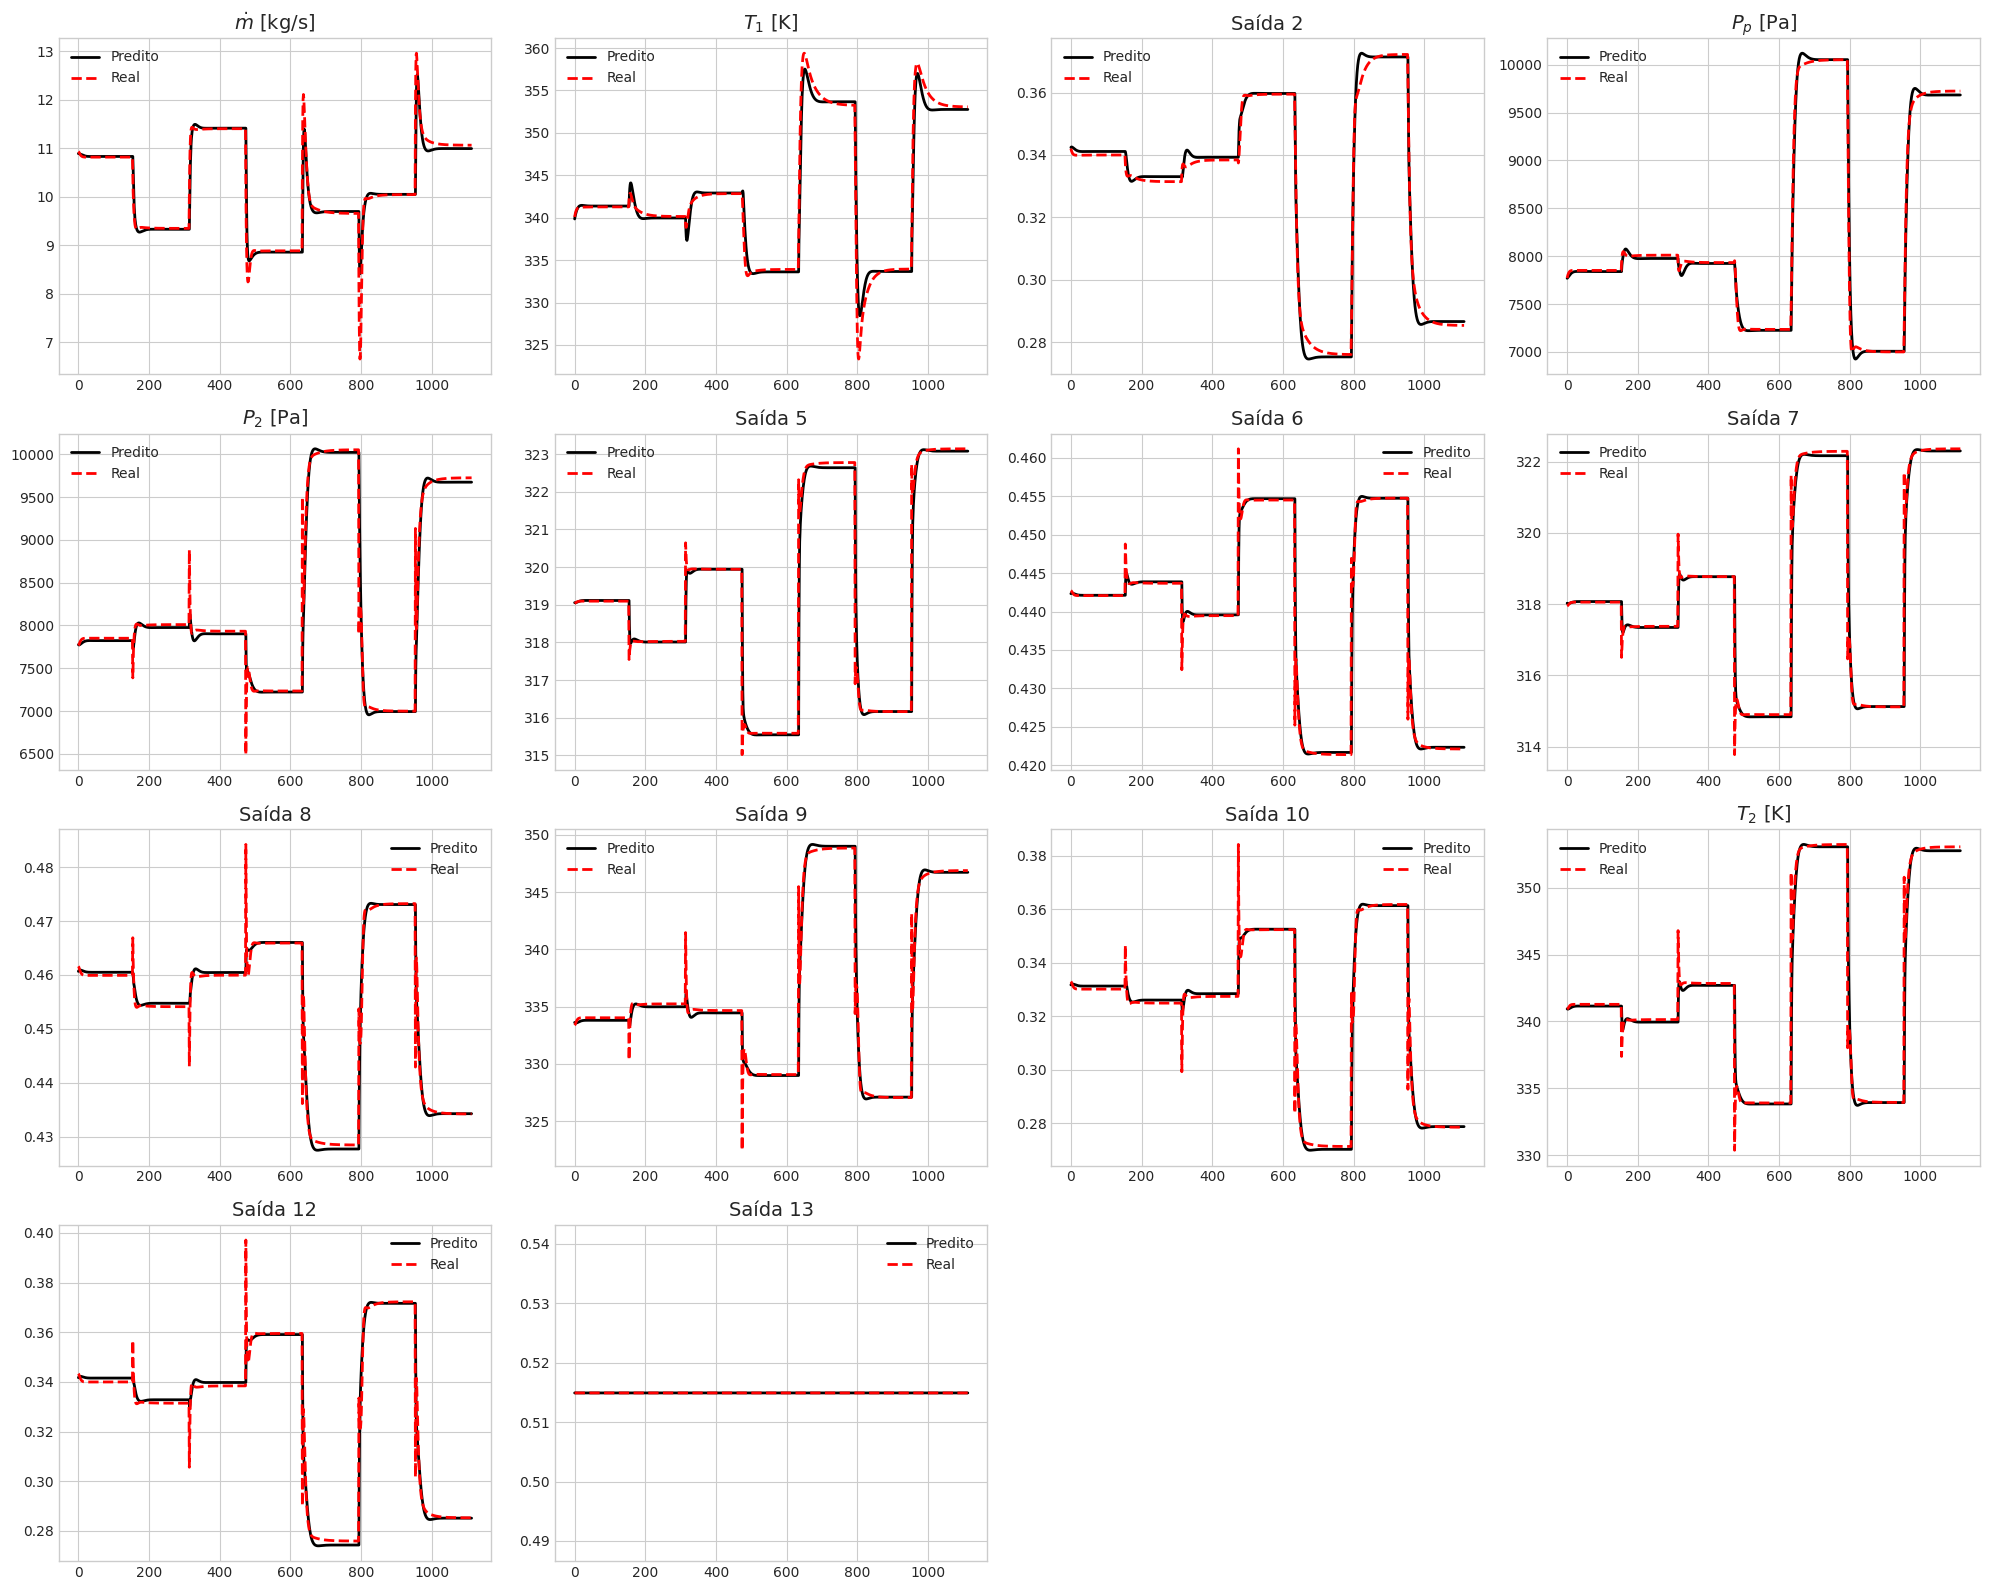

In [50]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("seaborn-v0_8-whitegrid")

# Converter listas para numpy arrays (removendo os 3 primeiros)
massFlowrate_pred = np.array(massFlowrate_pred[3:])
Temperatura_pred = np.array(Temperatura_pred[3:])
PlenumPressure_pred = np.array(PlenumPressure_pred[3:])
Pressure2_pred = np.array(Pressure2_pred[3:])
Temperatura2_pred = np.array(Temperatura2_pred[3:])
all_predictions = np.array(all_predictions)[3:]  # se necessário

# Assegurar que y_teste também tem 3 removidos
y_teste = np.array(y_teste)[3:]

# Configurações dos títulos e unidades (exemplos genéricos, ajuste conforme necessário)
labels = [
    r'$\dot{m}$ [kg/s]', r'$T_1$ [K]', r'Saída 2', r'$P_p$ [Pa]', r'$P_2$ [Pa]', r'Saída 5',
    r'Saída 6', r'Saída 7', r'Saída 8', r'Saída 9', r'Saída 10', r'$T_2$ [K]',
    r'Saída 12', r'Saída 13'
]

# Criar a figura com subplots
fig, axs = plt.subplots(4, 4, figsize=(20, 16))
axs = axs.ravel()

for i in range(14):
    axs[i].plot(all_predictions[:, i], label='Predito', color='black', linewidth=2)
    axs[i].plot(y_teste[:, i], label='Real', color='red', linestyle='--', linewidth=2)
    axs[i].set_title(labels[i], fontsize=14)
    axs[i].legend(fontsize=10)
    axs[i].tick_params(axis='both', labelsize=10)

# Remover subplots extras (índices 14 e 15 do grid 4x4)
for j in range(14, 16):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()
